In [1]:
from pathlib import Path
import sys


import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx

import optax
import h5py

import matplotlib.pyplot as plt

Let's now train a neural network to learn how to approximate the data. Let's start by loading our data and organizing it into jax.

In [2]:
DATA_FILE = Path("../../outputs/poisson_pressure_simulations.h5")

with h5py.File(DATA_FILE, "r") as f:
    print(f.keys())
    
    X = jnp.array(f["positions"])
    T = jnp.array(f["kl_transform_matrice"])
    P = jnp.array(f["pressure_fields"])
    θ = jnp.array(f["kl_coefficients"])
    Y = jnp.array(f["Y_fields"])
    
    

<KeysViewHDF5 ['Y_fields', 'kl_coefficients', 'kl_transform_matrice', 'positions', 'pressure_fields', 'sensor_position_indexes']>


Since this time i'll not be able to easily simulate stuff let's separate a training and test set.

In [3]:
TESTING_DATA_FILE = Path("../../outputs/poisson_pressure_simulations_test.h5")

with h5py.File(TESTING_DATA_FILE, "r") as f:
    print(f.keys())
    
    X_test = jnp.array(f["positions"])
    T_test = jnp.array(f["kl_transform_matrice"])
    P_test = jnp.array(f["pressure_fields"])
    θ_test = jnp.array(f["kl_coefficients"])
    Y_test = jnp.array(f["Y_fields"])
    

<KeysViewHDF5 ['Y_fields', 'kl_coefficients', 'kl_transform_matrice', 'positions', 'pressure_fields', 'sensor_position_indexes']>


# Model definition

Let's now use equinox to define our network.

In [4]:
from typing import Callable

class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]
        


In [5]:
@eqx.filter_jit
def loss_fn(model, X, θ, P):
    outputs = jax.vmap(jax.vmap(model, in_axes=(None, 0)), in_axes=(0, None))(θ, X)

    mse = jnp.mean(jnp.square(outputs - P))

    return mse


@eqx.filter_jit
def update(opt_state, model):
    
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, X, θ, P)
    updates, new_state = optmizer.update(grad, opt_state, model)
    new_model = eqx.apply_updates(model, updates)

    return loss, new_model, new_state

In [6]:
key = jax.random.key(1325)

deeponet = DeepOnet(
    24,
    2,
    256,
    5,
    128,
    activation=jax.nn.relu,
    key=key
)

losses = []
test_losses = []

Training has been conducted using a python script for more robustness against remote server connection problems. Let's load the resulting best model and see how it behaves in respect to the training data!

In [8]:
import json
# sys.path.append("../../modules/")

# from training_deeponet import LossTrainingState

# with open("../../training_cache/loss_history.json", "r") as f:
#     loss_history = LossTrainingState(**json.load(f))

best_model = eqx.tree_deserialise_leaves("../../outputs/fivespot_deeponet_best.eqx", deeponet)

In [16]:
%%timeit
loss_fn(best_model, X, θ, P)

120 ms ± 488 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


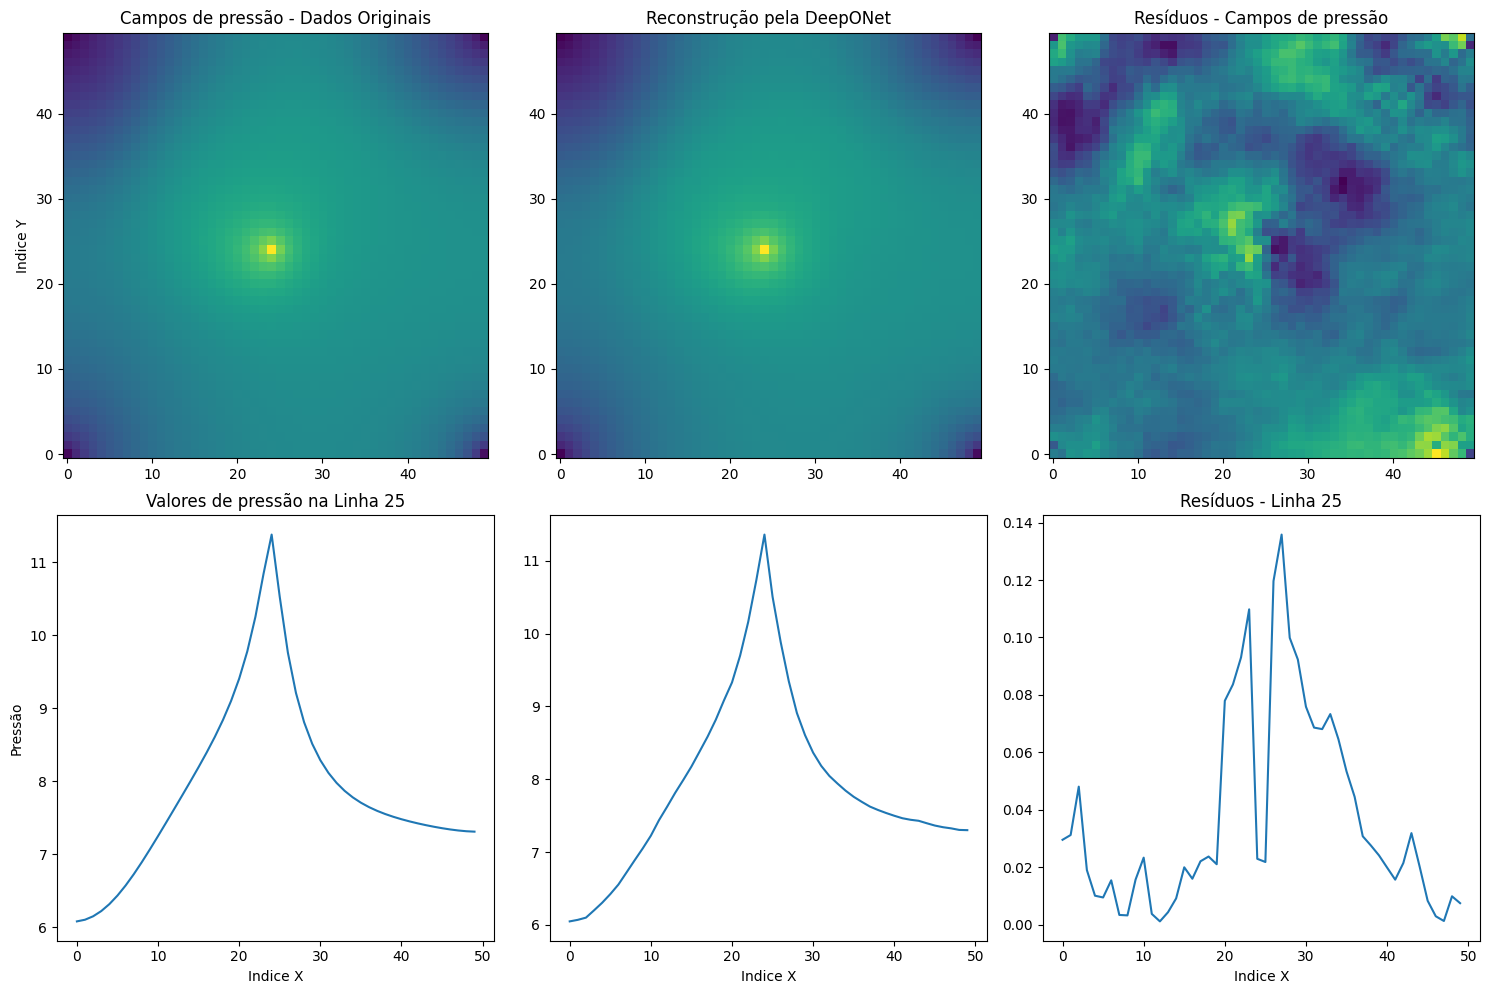

In [9]:
id_ = 132

out = jax.vmap(best_model, in_axes=(None, 0))(θ_test[id_], X_test).reshape(50, 50)
original = P_test[id_].reshape(50, 50)


fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(ncols=3, nrows=2, figsize=(15, 10),)

diff =  original - out

ax1.imshow(original, origin="lower")
ax2.imshow(out, origin="lower")
ax3.imshow(diff, origin="lower")

ax1.set(title="Campos de pressão - Dados Originais", ylabel="Indice Y")
ax2.set(title="Reconstrução pela DeepONet")
ax3.set(title="Resíduos - Campos de pressão")


ax4.plot(original[25, :])
ax4.set(title="Valores de pressão na Linha 25", xlabel="Indice X", ylabel="Pressão")

ax5.plot(out[25, :])
ax5.set(xlabel="Indice X")

ax6.plot(abs(original[25, :] - out[25, :]))
ax6.set(title="Resíduos - Linha 25", xlabel="Indice X")

plt.tight_layout()

(0.0, 0.1)

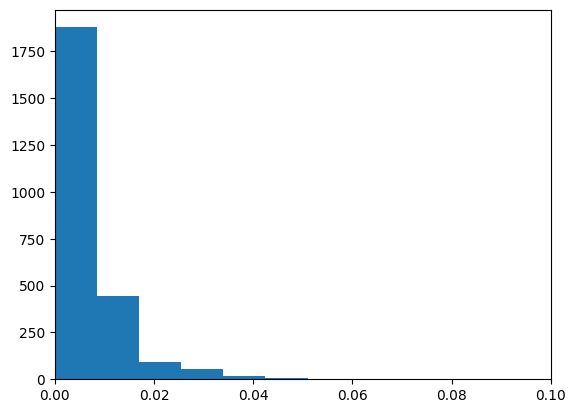

In [16]:
plt.hist(abs(diff/original).ravel(), bins=50)
plt.xlim(0, 0.1)

It looks like good enough for starting to work wth inversion!